# Louis George    

## Cleaning, and EDA of Scraped Script and Score Data

In [1]:
import numpy as np
import pandas as pd

import re
import json

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## IMSDb Data

In [2]:
df = pd.read_csv('../../data/scripts_upto_all.csv', index_col='Unnamed: 0')

In [3]:
df.head(2)

,titles,scripts,genres
0,10 Things I Hate About You,TEN THINGS I HA...,"['Action', 'Adventure', 'Animation', 'Comedy',..."
1,12,\n \n\n\n\n\nCUT FROM BLACK\n\nTITLE: FIN\n...,"['Action', 'Adventure', 'Animation', 'Comedy',..."


In [4]:
df.shape

(1210, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1210 entries, 0 to 1209
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   titles   1210 non-null   object
 1   scripts  1145 non-null   object
 2   genres   1210 non-null   object
dtypes: object(3)
memory usage: 37.8+ KB


In [6]:
df.isna().sum()

titles      0
scripts    65
genres      0
dtype: int64

In [7]:
df[df['scripts'].isna()]

,titles,scripts,genres
17,48 Hrs.,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
20,8 Mile,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
22,9,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
29,A.I.,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
122,Back to the Future,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
...,...,...,...
1121,Troy,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
1136,Unforgiven,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
1142,Valentine's Day,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
1146,Vertigo,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."


After checking some of these titles, the link to the script loads a pdf, or other document type. The script that I currently have can't handle such documents. Time allowing I may revisit this.     

Now because of the way my script grabbed the genres, I also grabbed a table with links to all 18 of the various genres. This table always got read before the script genres, and so by taking everything after the first 18 I should be left with each scripts respective genre.

In [8]:
for i in range(df.shape[0]):
    df['genres'][i] = df['genres'][i].split()
    df['genres'][i] = df['genres'][i][18:]
    for j in range(len(df['genres'][i])):
        temp = re.findall('[A-Za-z]', df['genres'][i][j])
        word = ''.join(temp)
        df['genres'][i][j] = word
    df['genres'][i] = '|'.join(df['genres'][i])

I will now drop all 65 of the movies which I wasn't able to obtain the script for.

In [9]:
df = df.dropna().reset_index().drop('index', axis=1)

Need to change format of all titles with the form: "title, The", and "Title: sub title"    

Turns out it handles the vast majority of the form: "Title: sub title" properly, and that only a handful don't go through. For that reason I am going to let them go, as there doesn't seem to be an immediatly obvious solution to capture the ones that don't go through and leave the ones that do alone (Some titles rely on both the title and sub title).   

I guess that I could do it dynamically when querying: try the whole whole title, and if not correct result try with the partial title. Will do this if time permits.

In [10]:
for i in range(df.shape[0]):
    if re.search("The$", df['titles'][i]):
        n_title = "The " + re.split(", ", df['titles'][i])[0]
        df['titles'][i] = n_title

Now to save the titles as a csv for use to cross reference against the OMDb API and get the scores.

In [11]:
df['titles'].to_csv('../../data/movie_titles.csv', header='titles')

## OMDB API Data

First set, and initial investigation as I wait for the second set:

In [12]:
df_scores1 = pd.read_csv('../../data/movie_info1.csv').drop('Unnamed: 0', axis=1)

In [13]:
df_scores1.head()

,titles,info
0,10 Things I Hate About You,"{""Title"":""10 Things I Hate About You"",""Year"":""..."
1,12,"{""Title"":""12"",""Year"":""2007"",""Rated"":""PG-13"",""R..."
2,12 and Holding,"{""Title"":""12 and Holding"",""Year"":""2005"",""Rated..."
3,12 Monkeys,"{""Title"":""12 Monkeys"",""Year"":""1995"",""Rated"":""R..."
4,12 Years a Slave,"{""Title"":""12 Years a Slave"",""Year"":""2013"",""Rat..."


In [14]:
df_scores1.isna().any()

titles    False
info      False
dtype: bool

In [15]:
temp = json.loads(df_scores1['info'][9])

In [16]:
temp

{'Title': '187',
 'Year': '2016',
 'Rated': 'N/A',
 'Released': '19 Sep 2016',
 'Runtime': 'N/A',
 'Genre': 'Short, Crime',
 'Director': 'Hecht Amar',
 'Writer': 'N/A',
 'Actors': 'Hecht Amar, Mattia Bianchi',
 'Plot': 'N/A',
 'Language': 'English',
 'Country': 'USA',
 'Awards': 'N/A',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BMTg0NjYxZjQtNGY5Yy00OTNkLWEzODgtN2M2ZTAwMTU4YjBjL2ltYWdlL2ltYWdlXkEyXkFqcGdeQXVyMzI5OTA2MjM@._V1_SX300.jpg',
 'Ratings': [],
 'Metascore': 'N/A',
 'imdbRating': 'N/A',
 'imdbVotes': 'N/A',
 'imdbID': 'tt6217824',
 'Type': 'movie',
 'DVD': 'N/A',
 'BoxOffice': 'N/A',
 'Production': 'N/A',
 'Website': 'N/A',
 'Response': 'True'}

**Function which gets all of the target data out of the json:**

In [17]:
def get_scores(df):
    df['IMDb_score'], df['RT_score'], df['Meta_score'], df['box_office'], df['ID'] = np.nan, np.nan, np.nan, np.nan, np.nan

    for i in range(df.shape[0]):
        temp = json.loads(df['info'][i])
        try:
            for j in temp['Ratings']:
                if j['Source'] == 'Internet Movie Database':
                    df['IMDb_score'][i] = j['Value']
                elif j['Source'] == 'Rotten Tomatoes':
                    df['RT_score'][i] = j['Value']
                elif j['Source'] == 'Metacritic':
                    df['Meta_score'][i] = j['Value']
            df['box_office'][i] = temp['BoxOffice']
            df['ID'][i] = temp['imdbID']
        except:
            #print("Exception triggered")
            df['IMDb_score'][i] = np.nan
            df['RT_score'][i] = np.nan
            df['Meta_score'][i] = np.nan
            df['box_office'][i] = np.nan

In [18]:
get_scores(df_scores1)

In [19]:
df_scores1.head()

,titles,info,IMDb_score,RT_score,Meta_score,box_office,ID
0,10 Things I Hate About You,"{""Title"":""10 Things I Hate About You"",""Year"":""...",7.3/10,68%,70/100,N/A,tt0147800
1,12,"{""Title"":""12"",""Year"":""2007"",""Rated"":""PG-13"",""R...",7.7/10,76%,72/100,N/A,tt0488478
2,12 and Holding,"{""Title"":""12 and Holding"",""Year"":""2005"",""Rated...",7.5/10,73%,65/100,N/A,tt0417385
3,12 Monkeys,"{""Title"":""12 Monkeys"",""Year"":""1995"",""Rated"":""R...",8.0/10,89%,74/100,N/A,tt0114746
4,12 Years a Slave,"{""Title"":""12 Years a Slave"",""Year"":""2013"",""Rat...",8.1/10,95%,96/100,"$50,628,650",tt2024544


In [20]:
df_scores1.isna().sum()

titles         0
info           0
IMDb_score    27
RT_score      58
Meta_score    72
box_office    24
ID            24
dtype: int64

In [21]:
df_scores1[df_scores1['RT_score'].isna()].head()

,titles,info,IMDb_score,RT_score,Meta_score,box_office,ID
9,187,"{""Title"":""187"",""Year"":""2016"",""Rated"":""N/A"",""Re...",NaN,NaN,NaN,N/A,tt6217824
17,50-50,"{""Title"":""50-50"",""Year"":""2011"",""Rated"":""N/A"",""...",6.1/10,NaN,NaN,N/A,tt1833204
30,Adaptation,"{""Title"":""Adaptation"",""Year"":""2019–"",""Rated"":""...",NaN,NaN,NaN,NaN,NaN
33,The Adventures of Buckaroo Banzai Across the E...,"{""Response"":""False"",""Error"":""Movie not found!""}",NaN,NaN,NaN,NaN,NaN
35,After School Special,"{""Title"":""After School Special"",""Year"":""2017"",...",2.3/10,NaN,NaN,N/A,tt3291632


**Function which cleans up the score features:**

In [22]:
def score_cleaner(df, col):
    for i in range(df.shape[0]):
        try:
            if col[i] == 'N/A':
                col[i] = np.nan
            elif '/' in col[i]:
                y = col[i].split('/')
                col[i] = round(float(y[0]) / float(y[1]), 2)
            elif '%' in col[i]:
                col[i] = round(int(col[i].split('%')[0]) / 100, 2)
            elif ("$" in col[i]) | ("estimated" in col[i]):
                col[i] = int(''.join(re.findall('[0-9]', col[i])))
        except:
            continue

In [23]:
score_cleaner(df_scores1, df_scores1['IMDb_score'])
score_cleaner(df_scores1, df_scores1['RT_score'])
score_cleaner(df_scores1, df_scores1['Meta_score'])
score_cleaner(df_scores1, df_scores1['box_office'])

In [24]:
df_scores1.isna().sum()

titles          0
info            0
IMDb_score     27
RT_score       58
Meta_score     72
box_office    312
ID             24
dtype: int64

____________________________________________________
**Second set:**

In [25]:
df_scores2 = pd.read_csv('../../data/movie_info2.csv').drop('Unnamed: 0', axis=1)

In [26]:
df_scores2.shape

(645, 2)

In [27]:
get_scores(df_scores2)
score_cleaner(df_scores2, df_scores2['IMDb_score'])
score_cleaner(df_scores2, df_scores2['RT_score'])
score_cleaner(df_scores2, df_scores2['Meta_score'])
score_cleaner(df_scores2, df_scores2['box_office'])

In [28]:
df_scores2.head()

,titles,info,IMDb_score,RT_score,Meta_score,box_office,ID
0,Hellraiser,"{""Title"":""Hellraiser"",""Year"":""1987"",""Rated"":""R...",0.7,0.7,0.57,NaN,tt0093177
1,Hellraiser 3: Hell on Earth,"{""Response"":""False"",""Error"":""Movie not found!""}",NaN,NaN,NaN,NaN,NaN
2,Hellraiser: Deader,"{""Title"":""Hellraiser: Deader"",""Year"":""2005"",""R...",0.46,0.17,NaN,NaN,tt0337636
3,Hellraiser: Hellseeker,"{""Title"":""Hellraiser: Hellseeker"",""Year"":""2002...",0.5,0,0.46,NaN,tt0274546
4,The Help,"{""Title"":""The Help"",""Year"":""2011"",""Rated"":""PG-...",0.81,0.76,0.62,169705587,tt1454029


In [29]:
df_scores2.isna().sum()

titles          0
info            0
IMDb_score     38
RT_score       79
Meta_score    114
box_office    354
ID             33
dtype: int64

__________________________________

Judging from the results of the omdbapi scraping, the box office revenue, and Metacritic score are unusable, and I will have to drop those columns entirely.    

I will have to drop about 10% of the remainder of my rows in order to use Rotten Tomatoes, and IMDb scores.    

Overall this isn't ideal, as my dataset is already relatively small. If time permits, I may revisit the scraper and try to optimize more.

__________________________________

From these figures it would appear as though we need to drop box office, however we are given the imdb movie ID, which will allow me to scrape their website relatively easily (ie sans Selenium). I'll do that and see if I can get enough data to work with.

For that I need to export the IDs for the scraper to do it's thing. To do this, as well as proceed with the project anyway I will need to join the two dataframes:

In [30]:
df_scores1 = df_scores1.drop(['info', 'Meta_score', 'box_office'], axis=1)
df_scores2 = df_scores2.drop(['info', 'Meta_score', 'box_office'], axis=1)
df_scores = pd.concat([df_scores1, df_scores2], axis=0).reset_index(drop=True)

In [31]:
df_scores.head()

,titles,IMDb_score,RT_score,ID
0,10 Things I Hate About You,0.73,0.68,tt0147800
1,12,0.77,0.76,tt0488478
2,12 and Holding,0.75,0.73,tt0417385
3,12 Monkeys,0.8,0.89,tt0114746
4,12 Years a Slave,0.81,0.95,tt2024544


In [32]:
df_scores.shape

(1145, 4)

Exporting the movie ids for IMDb scraper:

In [34]:
df_scores['ID'].to_csv('../web_scrapers/imbd_ids.csv', header='ID')

___________________________________    
## IMDb Data
Importing the scraped data:

In [35]:
df_imdb = pd.read_csv('../../data/imdb_scrape.csv', index_col='Unnamed: 0').reset_index(drop=True)

In [36]:
df_imdb['info'][0].split('\n')

['Edit',
 'Details',
 'Country: USA',
 'Language: English | French',
 'Release Date: 31 March 1999 (USA) See more »',
 'Also Known As: 10 Things I Hate About You See more »',
 'Filming Locations: 2715 North Junett Street, Tacoma, Washington, USA See more »',
 'Edit',
 'Box Office',
 'Budget:$30,000,000 (estimated)',
 'Opening Weekend USA: $8,330,681, 4 April 1999',
 'Gross USA: $38,178,166',
 'Cumulative Worldwide Gross: $53,478,166',
 'See more on IMDbPro »',
 'Company Credits',
 'Production Co: Touchstone Pictures, Mad Chance, Jaret Entertainment See more »',
 'Show more on IMDbPro »',
 'Technical Specs',
 'Runtime: 97 min',
 'Sound Mix: Dolby Digital | SDDS | DTS',
 'Color: Color',
 'Aspect Ratio: 1.85 : 1',
 'See full technical specs »']

In [37]:
df_scores['Gross_world'], df_scores['Gross_US'], df_scores['Opening_US'], df_scores['Budget'] = np.nan, np.nan, np.nan, np.nan

for i in range(df_imdb.shape[0]):
    if type(df_imdb['info'][i]) == float:
        pass
    else:
        for j in df_imdb['info'][i].split('\n'):
            if 'Budget' in j:
                df_scores['Budget'][i] = j
            if 'Opening' in j:
                df_scores['Opening_US'][i] = j
            if 'Gross USA' in j:
                df_scores['Gross_US'][i] = j
            if 'Cumulative' in j:
                df_scores['Gross_world'][i] = j

In [38]:
df_imdb.shape

(1145, 2)

In [39]:
df_scores.shape

(1145, 8)

In [40]:
df_imdb.isna().sum()

ID      57
info    58
dtype: int64

In [41]:
df_scores.isna().sum()

titles           0
IMDb_score      65
RT_score       137
ID              57
Gross_world    153
Gross_US       178
Opening_US     211
Budget         162
dtype: int64

In [42]:
df_scores[df_scores['Budget'].isna()].isna().sum()

titles           0
IMDb_score      64
RT_score       102
ID              57
Gross_world    112
Gross_US       111
Opening_US     116
Budget         162
dtype: int64

In [43]:
df_scores[df_scores['Budget'].isna()]

,titles,IMDb_score,RT_score,ID,Gross_world,Gross_US,Opening_US,Budget
16,44 Inch Chest,0.58,0.41,tt0914837,"Cumulative Worldwide Gross: $294,245","Gross USA: $39,033","Opening Weekend USA: $4,185, 17 January 2010",NaN
17,50-50,0.61,NaN,tt1833204,NaN,NaN,NaN,NaN
22,A Prayer Before Dawn,0.69,0.92,tt4080956,"Cumulative Worldwide Gross: $958,883","Gross USA: $14,453","Opening Weekend USA: $14,453, 12 August 2018",NaN
30,Adaptation,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,The Adventures of Buckaroo Banzai Across the E...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1119,Wild Things: Diamonds in the Rough,0.45,NaN,tt0448179,NaN,NaN,NaN,NaN
1122,Win Win,0.71,0.94,tt1606392,"Cumulative Worldwide Gross: $11,789,613","Gross USA: $10,179,275","Opening Weekend USA: $150,362, 20 March 2011",NaN
1124,Withnail and I,0.53,NaN,tt0870218,NaN,NaN,NaN,NaN
1130,The Woodsman,0.72,0.88,tt0361127,"Cumulative Worldwide Gross: $4,678,405","Gross USA: $1,576,231","Opening Weekend USA: $53,985, 26 December 2004",NaN


In [44]:
df_scores.head()

,titles,IMDb_score,RT_score,ID,Gross_world,Gross_US,Opening_US,Budget
0,10 Things I Hate About You,0.73,0.68,tt0147800,"Cumulative Worldwide Gross: $53,478,166","Gross USA: $38,178,166","Opening Weekend USA: $8,330,681, 4 April 1999","Budget:$30,000,000 (estimated)"
1,12,0.77,0.76,tt0488478,"Cumulative Worldwide Gross: $7,537,453","Gross USA: $125,120","Opening Weekend USA: $12,042, 8 March 2009","Budget:$4,000,000 (estimated)"
2,12 and Holding,0.75,0.73,tt0417385,"Cumulative Worldwide Gross: $119,195","Gross USA: $96,464","Opening Weekend USA: $11,456, 21 May 2006","Budget:$400,000 (estimated)"
3,12 Monkeys,0.8,0.89,tt0114746,"Cumulative Worldwide Gross: $168,839,459","Gross USA: $57,141,459","Opening Weekend USA: $184,776, 1 January 1996","Budget:$29,000,001 (estimated)"
4,12 Years a Slave,0.81,0.95,tt2024544,"Cumulative Worldwide Gross: $187,733,202","Gross USA: $56,671,993","Opening Weekend USA: $923,715, 20 October 2013","Budget:$20,000,000 (estimated)"


In [45]:
print(f"With 'Opening_US' dropped: {df_scores.drop(['titles', 'ID', 'Opening_US'], axis=1).dropna().shape}")
print(f"With 'Opening_US', and 'Gross_US' dropped: {df_scores.drop(['titles', 'ID', 'Opening_US', 'Gross_US'], axis=1).dropna().shape}")
print(f"With 'Opening_US', and 'Gross_world' dropped: {df_scores.drop(['titles', 'ID', 'Opening_US', 'Gross_world'], axis=1).dropna().shape}")
print(f"With all 3 dropped: {df_scores.drop(['titles', 'ID', 'Opening_US', 'Gross_US', 'Gross_world'], axis=1).dropna().shape}")


With 'Opening_US' dropped: (898, 5)
With 'Opening_US', and 'Gross_US' dropped: (922, 4)
With 'Opening_US', and 'Gross_world' dropped: (898, 4)
With all 3 dropped: (948, 3)


From the results of our scrape of IMDb, I will have to widdle down my dataset from 1145 scripts to either as high as 948, or as low as 898, depending on which targets I decide to include. Moving forward I will take the middle ground of 922, and drop both the Opening US, and Gross US tagerts, and continue with IMDb score, RT score, Budget, and Gross world. Once I have a completed pipeline I may revisit this decision.

In [46]:
df_scores = df_scores.drop(['ID', 'Opening_US', 'Gross_US'], axis=1)

In [47]:
score_cleaner(df_scores, df_scores['Budget'])
score_cleaner(df_scores, df_scores['Gross_world'])

In [48]:
df_scores.head()

,titles,IMDb_score,RT_score,Gross_world,Budget
0,10 Things I Hate About You,0.73,0.68,53478166,30000000
1,12,0.77,0.76,7537453,4000000
2,12 and Holding,0.75,0.73,119195,400000
3,12 Monkeys,0.8,0.89,168839459,29000001
4,12 Years a Slave,0.81,0.95,187733202,20000000


In [49]:
df_scores.columns

Index(['titles', 'IMDb_score', 'RT_score', 'Gross_world', 'Budget'], dtype='object')

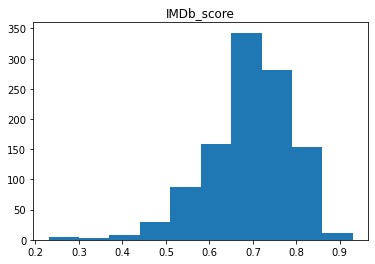

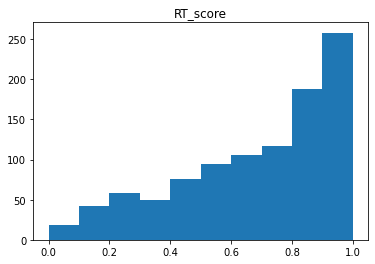

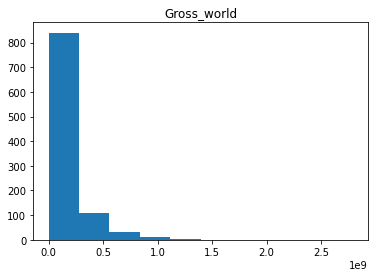

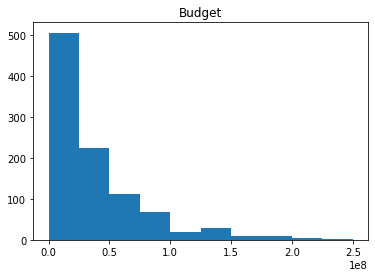

In [50]:
for i in df_scores.columns[1:]:
    plt.figure()
    plt.hist(df_scores[i])
    plt.title(i)
    plt.show();

Combining the final dataframes in order to drop the nans:

In [51]:
df_combined = pd.concat([df_scores, df.drop('titles', axis=1)], axis=1)

In [52]:
df_combined.columns

Index(['titles', 'IMDb_score', 'RT_score', 'Gross_world', 'Budget', 'scripts',
       'genres'],
      dtype='object')

In [53]:
df_fc = df_combined.dropna().reset_index(drop=True)

In [54]:
df_fc.index

RangeIndex(start=0, stop=922, step=1)

As shown we are left with the expected number of rows after dropping all nulls.

Now to export a clean dataset:

In [55]:
df_fc.to_csv('../../data/df_clean.csv', columns=df_fc.columns, index=False)